# Transfer Learning with TensorFlow Part 1: Feature Extraction
Transfer learning is leveraging a working model's existing archtecture and lerned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data our own, then we can adapt those patterns to our own data.

In [2]:
# Are we using a gpu
!nvidia-smi

Wed Dec 27 14:29:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 43%   64C    P0    48W / 180W |   1721MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Downloading and becoming one with the data

In [ ]:
# import zipfile

# Download the data
!wget "../https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("../10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in 10_food_classes_10_percent.
There are 10 directories and 0 images in 10_food_classes_10_percent/test.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings.
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza.
There are 

# Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [17]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "./10_food_classes_10_percent/train/"
test_dir = "./10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMG_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                                       target_size=IMG_SHAPE,
                                                       batch_size=BATCH_SIZE,
                                                       class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model ckeckpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [19]:
# Create TensorBoard callback (functionized bevause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to : {log_dir}")
    return tensorboard_callback

# Creating models using TensorFlow Hub

In the past we've used TensorFLow to create our own models layer by layer from scratch.

Now we we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

Browsing the TensorFlow Hub page and sorting for image classification.

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

In [ ]:

# Resnet 50 V2 feature vector
resnet_url = "https://kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/1"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/TensorFlow2/variations/b0-feature-vector/versions/1"

mobilenet_url = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"

In [11]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMG_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

# Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [12]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

2023-12-27 16:44:21.013449: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-27 16:44:22.879367: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [21]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                  validation_steps=len(test_data),
                                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                        experiment_name="resnet50V2")])

Saving TensorBoard log files to : tensorflow_hub/resnet50V2/20231227-170328
Epoch 1/5
24/24 [==============================] - 160s 7s/step - loss: 1.8800 - accuracy: 0.3787 - val_loss: 1.1803 - val_accuracy: 0.6240
Epoch 2/5
24/24 [==============================] - 157s 7s/step - loss: 0.9075 - accuracy: 0.7293 - val_loss: 0.8618 - val_accuracy: 0.7196
Epoch 3/5
24/24 [==============================] - 159s 7s/step - loss: 0.6126 - accuracy: 0.8227 - val_loss: 0.7535 - val_accuracy: 0.7544
Epoch 4/5
24/24 [==============================] - 169s 7s/step - loss: 0.4651 - accuracy: 0.8800 - val_loss: 0.7081 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 153s 7s/step - loss: 0.3735 - accuracy: 0.9173 - val_loss: 0.6698 - val_accuracy: 0.7848


Transfer learning feature extractor model out performed ALL of the previous models we  built by hand... (substanially) and in a quicker training time with only 10% of the training examples.

In [83]:
import matplotlib.pyplot as plt

def plot_loss_curves(history, save_path=None):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    
    # Add vertical dashed line at the end
    plt.axvline(x=max(epochs), color='gray', linestyle='--', linewidth=2)
    
    # Save or display the plotloss = history.history['loss']
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()
    
    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.grid()
    
    plt.axvline(x=max(epochs), color='gray', linestyle='--', linewidth=2)
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path.replace(".png", "_accuracy.png"))
    else:
        plt.show()

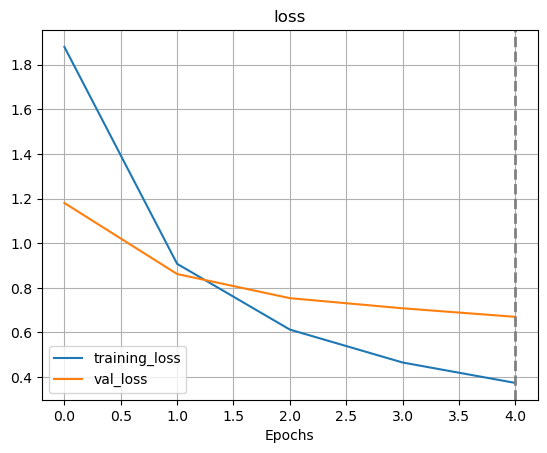

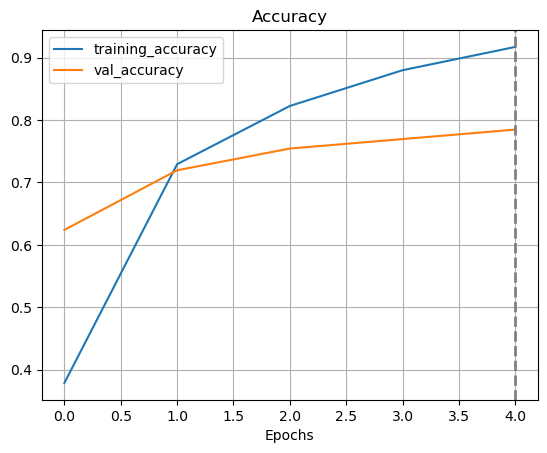

In [84]:
plot_loss_curves(resnet_history)

In [74]:
%tensorboard --logdir=./tensorflow_hub

In [55]:
!kill 10746

# Creating and testing EfficienctNetB0 TensorFlow Hub Feature Extraction model

In [48]:
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

In [49]:
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])

In [52]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                       epochs=5,
                                       steps_per_epoch=len(train_data_10_percent),
                                       validation_data=test_data,
                                       validation_steps=len(test_data),
                                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                             experiment_name="efficientnet")])

Saving TensorBoard log files to : tensorflow_hub/efficientnet/20231227-174348
Epoch 1/5
24/24 [==============================] - 124s 5s/step - loss: 1.8513 - accuracy: 0.4680 - val_loss: 1.3169 - val_accuracy: 0.7376
Epoch 2/5
24/24 [==============================] - 114s 5s/step - loss: 1.0549 - accuracy: 0.7907 - val_loss: 0.8685 - val_accuracy: 0.8232
Epoch 3/5
24/24 [==============================] - 114s 5s/step - loss: 0.7504 - accuracy: 0.8453 - val_loss: 0.6988 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 113s 5s/step - loss: 0.6024 - accuracy: 0.8720 - val_loss: 0.6139 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 116s 5s/step - loss: 0.5088 - accuracy: 0.8893 - val_loss: 0.5604 - val_accuracy: 0.8624


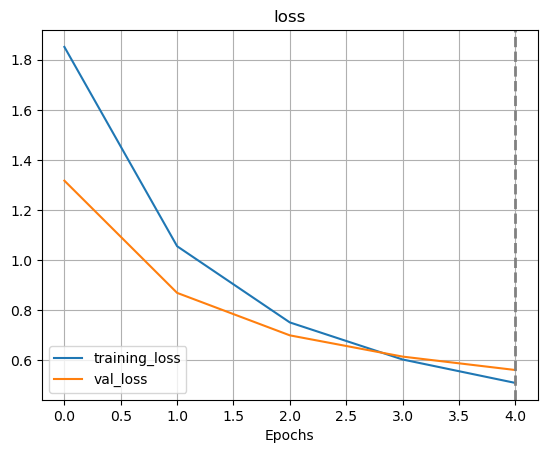

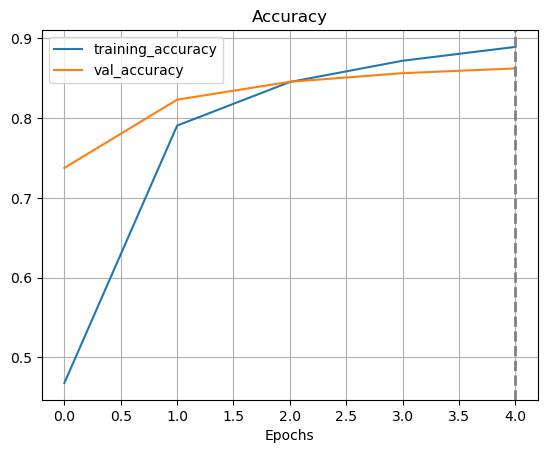

In [85]:
plot_loss_curves(efficientnet_history)

In [93]:
%tensorboard --logdir=./tensorflow_hub

Reusing TensorBoard on port 6006 (pid 20828), started 0:19:32 ago. (Use '!kill 20828' to kill it.)

In [60]:
!kill 10746

In [56]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [59]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [89]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

# Different types of transfer learning

* **"As is" transfer learning**  using an existing model with node changes what so ever (e.g using ImageNet)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g. EfficientNet) adjust the output layer for our own probelm (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many (including new output layer)

# Creating and testing MobileNet_v2 TensorFlow Hub Feature Extraction model

In [ ]:
mobilenet_model = create_model(mobilenet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
mobilenet_model.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

In [ ]:
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                       epochs=5,
                                       step_per_epoch=len(train_data_10_percent),
                                       validation_data=test_data,
                                       validation_steps=len(test_data),
                                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                             experiment_name="mobilenet")])

In [ ]:
plot_loss_curves(mobilenet_history)

In [ ]:
%tensorboard --logdir=./tensorflow_hub